The goal of this notebook is to create a russian-turkish-english version of  NLLB model out of the multilingual one.

In [1]:
#!pip install sentencepiece==0.1.99 transformers==4.33.2 datasets
!pip install sentencepiece transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.0 MB/s eta 0:00:00


# Removing the unused vocabulary

In [2]:
from transformers import AutoModelForSeq2SeqLM, NllbTokenizer
import torch
import datasets
import pandas as pd
pd.options.display.max_colwidth = 300
import csv
import sentencepiece.sentencepiece_model_pb2 as spmp
import random
import gc

In [3]:
from google.colab import drive
drive.mount('/Til')

Mounted at /Til


In [4]:
PATH = '/Til/MyDrive/Colab Notebooks/Til/'
DATA_PATH = "".join([PATH, 'Data/'])
DATA_PATH_EN_RU_CORPORA = f"{DATA_PATH}ru_en_corpora"


RU_FILE_NAME = f'{DATA_PATH_EN_RU_CORPORA}/rus-ru_web-public_2019_1M-sentences.txt'
EN_FILE_NAME = f'{DATA_PATH_EN_RU_CORPORA}/eng-com_web-public_2018_1M-sentences.txt'
TR_FILE_NAME = f'{DATA_PATH_EN_RU_CORPORA}/tur-tr_web_2019_1M-sentences.txt'

MODEL_NAME = "facebook/nllb-200-distilled-600M" # "google/mt5-base" "TSjB/NLLB-201-600M-QM-V1""facebook/nllb-200-1.3B"
MODEL_PATH = "".join([PATH, 'models/NLLB_v2/'])

LANG_UNICODE = 'krc_Cyrl'

OUTPUT_MODEL_NAME = 'nllb_2_raw'
CONFIG_MODEL_NAME = 'TSjB/NLLB-2-QM'

SAVE_MODEL_NAME = "".join([MODEL_PATH, OUTPUT_MODEL_NAME])

In [5]:
tokenizer = NllbTokenizer.from_pretrained(MODEL_NAME)
tokenizer

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.55k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

the `lang_code_to_id` attribute is deprecated. The logic is natively handled in the `tokenizer.adder_tokens_decoder` this attribute will be removed in `transformers` v4.38
the `fairseq_tokens_to_ids` attribute is deprecated. The logic is natively handled in the `tokenizer.adder_tokens_decoder` this attribute will be removed in `transformers` v4.38
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


NllbTokenizer(name_or_path='facebook/nllb-200-distilled-600M', vocab_size=256001, model_max_length=1024, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>', 'additional_special_tokens': ['ace_Arab', 'ace_Latn', 'acm_Arab', 'acq_Arab', 'aeb_Arab', 'afr_Latn', 'ajp_Arab', 'aka_Latn', 'amh_Ethi', 'apc_Arab', 'arb_Arab', 'ars_Arab', 'ary_Arab', 'arz_Arab', 'asm_Beng', 'ast_Latn', 'awa_Deva', 'ayr_Latn', 'azb_Arab', 'azj_Latn', 'bak_Cyrl', 'bam_Latn', 'ban_Latn', 'bel_Cyrl', 'bem_Latn', 'ben_Beng', 'bho_Deva', 'bjn_Arab', 'bjn_Latn', 'bod_Tibt', 'bos_Latn', 'bug_Latn', 'bul_Cyrl', 'cat_Latn', 'ceb_Latn', 'ces_Latn', 'cjk_Latn', 'ckb_Arab', 'crh_Latn', 'cym_Latn', 'dan_Latn', 'deu_Latn', 'dik_Latn', 'dyu_Latn', 'dzo_Tibt', 'ell_Grek', 'eng_Latn', 'epo_Latn', 'est_Latn', 'eus_Latn', 'ewe_Latn', 'fao_Latn', 'pes_Arab', '

In [6]:
gc.collect()

96

In [7]:
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)

config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

Our tokenizer contains 256K tokens,

In [8]:
print(tokenizer.vocab_size)

256001


The model has 615M parameters.

In [9]:
def msize(m):
    return sum(p.numel() for p in m.parameters())

original_size = msize(model)
print(msize(model))
print(msize(model.model.shared))
print('encoder')
print(msize(model.model.encoder))
print('decoder')
print(msize(model.model.decoder))

615073792
262354944
encoder
413511680
decoder
463917056


Input and output embeddings are 85.3% of the whole model

In [10]:
print(msize(model.model.shared) / msize(model))
print(msize(model.lm_head) / msize(model))
print(msize(model.lm_head) / msize(model) + msize(model.model.shared) / msize(model))

0.4265422253595224
0.4265422253595224
0.8530844507190448


# Determine the new tokens

Take a file from https://wortschatz.uni-leipzig.de/en/download/Russian as a representation of Russian language. It contains 1M sentences.

Also take a similar representation of English, because we want our model to be bilingual, and English shares few tokens with Russian.

For Qarachay-Malqar languages we take all collected data.

Let us look at the sentences

In [11]:
df_ru = pd.read_csv(RU_FILE_NAME, sep='\t', header=None, quoting=csv.QUOTE_NONE)
df_ru.columns = ['idx', 'text']
df_ru.sample(5)

,idx,text
175289,175290,Вылет в Калининград от 2349 рублей - Акция авиакомпания Победа.
436477,436478,"Мини-астероид, влетевший в атмосферу Земли ранним утром 15 февраля 2013 года возле южноуральского города-миллионника Челябинска, создал пылевой пояс вокруг Земли."
103449,103450,"В наше время крайне необходимы специалисты в области психиатрии, обладающие возвышенным сознанием."
717276,717277,"Прием прошел замечательно, все очень четко, вежливо, профессионально."
189586,189587,"Герои были куклы, напоминали мапет или улицу сезам."


In [12]:
df_en = pd.read_csv(EN_FILE_NAME, sep='\t', header=None, quoting=csv.QUOTE_NONE)
df_en.columns = ['idx', 'text']
df_en.sample(5)

,idx,text
860477,860478,"Those buttons are unlikely to be exposed in Gutenberg unless the author has made special provision for it, making this a common culprit for incompatibility."
961521,961522,Winnings are awarded for combinations of variously looking BAR symbols and cherries.
315219,315220,I enjoy game. but now I not play much game. after time I addicted with my friend car I look around for sport Honda I don’t have time for game. but I interesting game.
366011,366012,"I’m sad to see my tomatoes start fading from the garden, but in the fall and winter we get delicious winter squash to bake!"
822826,822827,"They have a great shrimp/mango taco, along with other delicious traditional offerings."


Count the tokens that the current model uses for representing the sentences.

In [13]:
df_tr = pd.read_csv(TR_FILE_NAME, sep='\t', header=None, quoting=csv.QUOTE_NONE)
df_tr.columns = ['idx', 'text']
df_tr.sample(5)

,idx,text
901142,901143,TÜRSAB Kuşadası Temsilciliği tarafından düzenlenen ve Aydın Valisi Yavuz Selim Köşger’in başkanlık yaptığı toplantı Kuşadası Batıhan Hotel’de gerçekleştirildi.
812142,812143,Size birkaç örnek vereyim.
27979,27980,"“Allah yolunda takvâya riâyet etmenizi, mücâhede de bulunmanızı, iyilikte bulunandan, yâhut günah işleyenden, kimden olursa olsun size emanet edilen şeylere riâyette bulunmanızı, emanete hıyânette bulunmamanızı tavsiye ederim."
591681,591682,Küçük çocuk bunu eğlenceli buldu ve görevi kabul etti.
444462,444463,"Güzel el yazısı ile ders konusunu özetler, formülleri tahtaya yazardı."


In [14]:
from collections import Counter
from tqdm.auto import tqdm, trange

cnt_ru = Counter()
tokenizer.src_lang = "rus_Cyrl"
for text in tqdm(df_ru.text[1:100000]):
    cnt_ru.update(tokenizer.encode(text))

cnt_en = Counter()
tokenizer.src_lang = "eng_Latn"
for text in tqdm(df_en.text[1:100000]):
    cnt_en.update(tokenizer.encode(text))


cnt_tr = Counter()
tokenizer.src_lang = "tur_Latn"
for text in tqdm(df_tr.text[1:100000]):
    cnt_tr.update(tokenizer.encode(text))

  0%|          | 0/99999 [00:00<?, ?it/s]

  0%|          | 0/99999 [00:00<?, ?it/s]

  0%|          | 0/99999 [00:00<?, ?it/s]

The share of russian tokens are 12.3% of the whole vocabulary.
For english is 15.5%. For turkish is 15.3%.

Overlap between russian and english is 60.8%. Maybe in russian a huge amount of english tokens.

Overlap between turkish and english is 71.2%.

In [15]:
gc.collect()

86

In [16]:
print(len(cnt_ru), len(cnt_ru)/tokenizer.vocab_size)
print(len(cnt_en), len(cnt_en)/tokenizer.vocab_size)
print(len(cnt_tr), len(cnt_tr)/tokenizer.vocab_size)

common = len(set(cnt_ru.keys()).intersection(set(cnt_en.keys())))
print(common, common / len(cnt_ru))

common = len(set(cnt_tr.keys()).intersection(set(cnt_en.keys())))
print(common, common / len(cnt_tr))

21465 0.08384732872137218
27536 0.10756207983562564
24572 0.09598400006249976
10212 0.4757512229210342
14584 0.5935210809050953


For russian 10K tokens cover over 99%.

For english is 96.4%, 20K cover 99.5%.

For turkish is 98.6%, 20K cover 99.8%.

In [17]:
print('ru')
for top in 10_000, 20_000, 30_000:
    print(top, sum(v for k, v in cnt_ru.most_common(top)) / sum(cnt_ru.values()))
print('en')
for top in 10_000, 20_000, 30_000:
    print(top, sum(v for k, v in cnt_en.most_common(top)) / sum(cnt_en.values()))
print('tr')
for top in 10_000, 20_000, 30_000:
    print(top, sum(v for k, v in cnt_tr.most_common(top)) / sum(cnt_tr.values()))

ru
10000 0.9900664104044682
20000 0.9995289928226865
30000 1.0
en
10000 0.9663368380871834
20000 0.9962161713443625
30000 1.0
tr
10000 0.9868631313729137
20000 0.9986194284941262
30000 1.0


Remember the old vocabulary, because we are going to replace it soon!

In [18]:
old_voc = tokenizer.get_vocab()
old_inv_voc = {v: k for k, v in old_voc.items()}

Look at the most used tokens. They are mostly service words or prefixes.

In [19]:
print(tokenizer.convert_ids_to_tokens([k for k, v in cnt_ru.most_common(30)]))
print(tokenizer.convert_ids_to_tokens([k for k, v in cnt_en.most_common(30)]))
print(tokenizer.convert_ids_to_tokens([k for k, v in cnt_tr.most_common(30)]))

[',', 'rus_Cyrl', '</s>', '.', '▁и', '▁в', '<unk>', '▁В', '▁А', '▁на', '▁не', '▁', '▁с', '-', '▁по', '▁что', 'ть', 'е', 'ли', '▁вы', '▁за', '▁от', '▁-', 'ки', '▁у', '▁из', 'т', '▁для', 'ми', 'л']
['eng_Latn', '</s>', ',', '.', '▁the', '▁to', '▁of', '▁and', '▁a', '<unk>', '▁in', 's', '▁is', '▁that', '▁for', '▁And', '-', '▁A', 'ed', '▁I', '▁it', '▁you', '▁with', '▁on', "'", 'ing', '▁As', '▁as', '▁be', '▁']
['tur_Latn', '</s>', '.', ',', '▁ve', '<unk>', 'ý', '▁bir', 'ı', "'", 'þ', 'lar', '▁bu', 'ları', 'ın', '▁ile', '▁için', '▁de', 'ler', '▁da', '▁', 'leri', 'ç', 'in', '▁Ancak', 'da', 'ş', 'ü', 'esi', 'li']


We try the following composition of vocabulary:
* 1K of top tokens of the original tokenizer (just in case)
* Top 10K of the English vocabulary (or more, to make the total number of tokens 20K)
* Top 10K of the Russian vocabulary (or more, to make the total number of tokens 20K)
* Top 10K of the Turkish vocabulary (or more, to make the total number of tokens 20K)
* 100 special tokens


In [20]:
new_tokens = set(range(1000))
for i, (k, v) in enumerate(cnt_ru.most_common(10_000)):
    if k not in new_tokens:
        new_tokens.add(k)

for i, (k, v) in enumerate(cnt_en.most_common(15_000)):
    if len(new_tokens) == 29_900:
        print(i, 'English tokens are included')
        break
    if k not in new_tokens:
        new_tokens.add(k)

for i, (k, v) in enumerate(cnt_tr.most_common(10_000)):
    if len(new_tokens) == 29_900:
        print(i, 'Turkish tokens are included')
        break
    if k not in new_tokens:
        new_tokens.add(k)

#for t in range(tokenizer.vocab_size - 100, tokenizer.vocab_size):
for t in list(tokenizer.id_to_lang_code.keys()):
    new_tokens.add(t)


#for t in tokenizer.additional_special_tokens_ids:
#    new_tokens.add(t)

# new_tokens = [x for x in new_tokens if x < tokenizer.sp_model_size]
print(len(new_tokens))
kept_ids = sorted(new_tokens)

the `id_to_lang_code` attribute is deprecated. The logic is natively handled in the `tokenizer.adder_tokens_decoder` this attribute will be removed in `transformers` v4.38


29914


In [21]:
tokenizer.id_to_lang_code[256000]

KeyError: 256000

The new vocabulary is only 11.7% of the original one.

In [23]:
len(kept_ids) / tokenizer.vocab_size

0.11685110605036698

The plot shows that the tokens that were more frequent in the original vocabulary more frequently get into the new vocabulary (so that the curve bends upward).

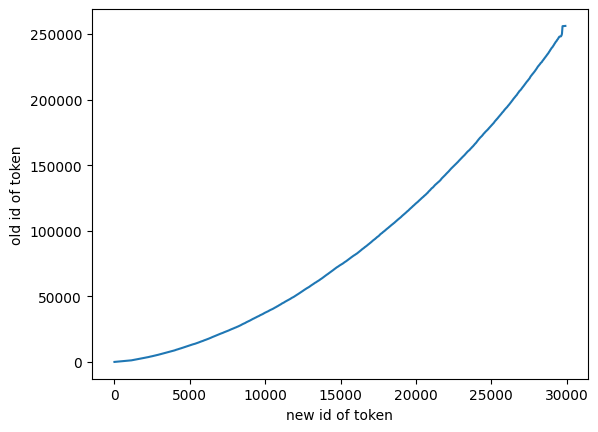

In [22]:
import matplotlib.pyplot as plt
plt.plot(kept_ids)
plt.xlabel('new id of token')
plt.ylabel('old id of token');

### Update the embeddings

In [24]:
new_size = len(kept_ids)
new_emb = torch.nn.Embedding(new_size, model.model.shared.embedding_dim, padding_idx=1)
new_head = torch.nn.Linear(in_features=model.lm_head.in_features, out_features=new_size, bias=False)

In [25]:
new_size

29914

In [26]:
for new_id, old_id in enumerate(kept_ids):
    new_emb.weight.data[new_id] = model.model.shared.weight.data[old_id]
    new_head.weight.data[new_id] = model.lm_head.weight.data[old_id]

In [27]:
model.model.shared.weight = new_emb.weight
model.lm_head.weight = new_head.weight

In [ ]:
#model.model.shared = new_emb
#model.lm_head = new_head

The new model has 656M parameters - 106,7% of the original size.

In [28]:
print(msize(model), msize(model) / original_size)

676337664 1.099604100836083


In [29]:
model

M2M100ForConditionalGeneration(
  (model): M2M100Model(
    (shared): Embedding(256206, 1024, padding_idx=1)
    (encoder): M2M100Encoder(
      (embed_tokens): Embedding(256206, 1024, padding_idx=1)
      (embed_positions): M2M100SinusoidalPositionalEmbedding()
      (layers): ModuleList(
        (0-11): 12 x M2M100EncoderLayer(
          (self_attn): M2M100Attention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): ReLU()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerNorm

### Update the tokenizer

NLLB uses Sentencepiece tokenizer, which is implemented in C and is opaque to Python.

Fortunately, we can download its model and deploy it into Python using its Protobuf representation.

https://github.com/google/sentencepiece/issues/121

In [55]:
#!wget https://raw.githubusercontent.com/google/sentencepiece/master/src/sentencepiece_model.proto

--2024-03-07 10:01:32--  https://raw.githubusercontent.com/google/sentencepiece/master/src/sentencepiece_model.proto
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14023 (14K) [text/plain]
Saving to: ‘sentencepiece_model.proto’

sentencepiece_model 100%[===================>]  13.69K  --.-KB/s    in 0s      

2024-03-07 10:01:33 (54.3 MB/s) - ‘sentencepiece_model.proto’ saved [14023/14023]



We compile the protobuf description of the sentencepiece model in order to be able to modify it.

In [63]:
#!protoc --python_out=. sentencepiece_model.proto

Now we can serialize the model used by the current tokenizer and open it as a protobuf class.

In [39]:
smp = tokenizer.sp_model.serialized_model_proto()
m = spmp.ModelProto()
m.ParseFromString(smp)

4852054

Filtered language tokens ("eng_Latn" and etc.)

In [104]:
#kept_ids_f = [x for x in kept_ids if x < len(m.pieces)]

In [40]:
kept_ids_f = [x for x in kept_ids if x not in list(tokenizer.id_to_lang_code.keys())]

In [41]:
print(len(kept_ids))
print(len(kept_ids_f))

29914
29712


In [42]:
print('the loaded model has pieces:', len(m.pieces))
new_pieces = [m.pieces[idx] for idx in kept_ids_f]
print('the new pieces:', len(new_pieces))

the loaded model has pieces: 256000
the new pieces: 29712


In [43]:
# replace the content of the first 30K pieces
for i, p in enumerate(new_pieces):
    m.pieces[i].piece = p.piece
    m.pieces[i].score = p.score
    m.pieces[i].type = p.type

# drop the remaining pieces
n = len(new_pieces)
for i in trange(len(m.pieces) - n):
    m.pieces.pop(len(m.pieces) - 1)

print(len(m.pieces))
with open('new_sp.model', 'wb') as f:
    f.write(m.SerializeToString())

  0%|          | 0/226288 [00:00<?, ?it/s]

29712


In [44]:
new_tokenizer = NllbTokenizer('new_sp.model', extra_ids=0)

In [45]:
new_tokenizer

NllbTokenizer(name_or_path='', vocab_size=29713, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>', 'additional_special_tokens': ['ace_Arab', 'ace_Latn', 'acm_Arab', 'acq_Arab', 'aeb_Arab', 'afr_Latn', 'ajp_Arab', 'aka_Latn', 'amh_Ethi', 'apc_Arab', 'arb_Arab', 'ars_Arab', 'ary_Arab', 'arz_Arab', 'asm_Beng', 'ast_Latn', 'awa_Deva', 'ayr_Latn', 'azb_Arab', 'azj_Latn', 'bak_Cyrl', 'bam_Latn', 'ban_Latn', 'bel_Cyrl', 'bem_Latn', 'ben_Beng', 'bho_Deva', 'bjn_Arab', 'bjn_Latn', 'bod_Tibt', 'bos_Latn', 'bug_Latn', 'bul_Cyrl', 'cat_Latn', 'ceb_Latn', 'ces_Latn', 'cjk_Latn', 'ckb_Arab', 'crh_Latn', 'cym_Latn', 'dan_Latn', 'deu_Latn', 'dik_Latn', 'dyu_Latn', 'dzo_Tibt', 'ell_Grek', 'eng_Latn', 'epo_Latn', 'est_Latn', 'eus_Latn', 'ewe_Latn', 'fao_Latn', 'pes_Arab', 'fij_La

### Save the model

In [56]:
model.config.__dict__['vocab_size'] = new_size
model.config.__dict__['_name_or_path'] = CONFIG_MODEL_NAME
model.config

M2M100Config {
  "_name_or_path": "TSjB/NLLB-2-QM",
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "architectures": [
    "M2M100ForConditionalGeneration"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0,
  "decoder_layers": 12,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0,
  "encoder_layers": 12,
  "eos_token_id": 2,
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "max_length": 200,
  "max_position_embeddings": 1024,
  "model_type": "m2m_100",
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "scale_embedding": true,
  "tokenizer_class": "NllbTokenizer",
  "torch_dtype": "float32",
  "transformers_version": "4.38.2",
  "use_cache": true,
  "vocab_size": 29914
}

In [47]:
new_tokenizer.save_pretrained(OUTPUT_MODEL_NAME)

('nllb_2_raw/tokenizer_config.json',
 'nllb_2_raw/special_tokens_map.json',
 'nllb_2_raw/sentencepiece.bpe.model',
 'nllb_2_raw/added_tokens.json')

In [112]:
model.save_pretrained(OUTPUT_MODEL_NAME)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


In [ ]:
!ls nllb_3_qm -alsh

total 2.6G
4.0K drwxr-xr-x 2 root root 4.0K Mar  4 07:36 .
4.0K drwxr-xr-x 1 root root 4.0K Mar  4 07:36 ..
4.0K -rw-r--r-- 1 root root  877 Mar  4 07:36 config.json
4.0K -rw-r--r-- 1 root root  184 Mar  4 07:36 generation_config.json
2.6G -rw-r--r-- 1 root root 2.6G Mar  4 07:36 pytorch_model.bin
828K -rw-r--r-- 1 root root 827K Mar  4 07:36 sentencepiece.bpe.model
4.0K -rw-r--r-- 1 root root 3.5K Mar  4 07:36 special_tokens_map.json
4.0K -rw-r--r-- 1 root root  597 Mar  4 07:36 tokenizer_config.json


Now try to load the model

In [48]:
gc.collect()

3581

In [57]:
tokenizer1 = NllbTokenizer.from_pretrained(OUTPUT_MODEL_NAME)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
model1 = AutoModelForSeq2SeqLM.from_pretrained(OUTPUT_MODEL_NAME)

RuntimeError: Error(s) in loading state_dict for M2M100ForConditionalGeneration:
	size mismatch for model.encoder.embed_tokens.weight: copying a param with shape torch.Size([262926, 1024]) from checkpoint, the shape in current model is torch.Size([29897, 1024]).
	size mismatch for model.decoder.embed_tokens.weight: copying a param with shape torch.Size([262926, 1024]) from checkpoint, the shape in current model is torch.Size([29897, 1024]).
	You may consider adding `ignore_mismatched_sizes=True` in the model `from_pretrained` method.

The model has not been fine-tuned on any sensible task except filling the gaps. And even this task is performed strangely - the models continues generating when it should have stopped.

But we hope that after fine-tuning it will be better. But this is the topic of the next story)

In [50]:
gc.collect()

0

In [58]:
def translate(text, src_lang='krc_Cyrl', tgt_lang='rus_Cyrl',
    a=32, b=3, max_input_length=1024, num_beams=4, **kwargs
):
    """Turn a text or a list of texts into a list of translations"""
    tokenizer1.src_lang = src_lang
    tokenizer1.tgt_lang = tgt_lang
    inputs = tokenizer1(
        text, return_tensors='pt', padding=True, truncation=True,
        max_length=max_input_length
    )
    model.eval() # turn off training mode
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer1.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        num_beams=num_beams, **kwargs
    )
    return tokenizer1.batch_decode(result, skip_special_tokens=True)

In [59]:
translate("Как дела?", tgt_lang='rus_Cyrl', src_lang='eng_Latn')

[',']

In [60]:
tokenizer.id_to_lang_code

{256001: 'ace_Arab',
 256002: 'ace_Latn',
 256003: 'acm_Arab',
 256004: 'acq_Arab',
 256005: 'aeb_Arab',
 256006: 'afr_Latn',
 256007: 'ajp_Arab',
 256008: 'aka_Latn',
 256009: 'amh_Ethi',
 256010: 'apc_Arab',
 256011: 'arb_Arab',
 256012: 'ars_Arab',
 256013: 'ary_Arab',
 256014: 'arz_Arab',
 256015: 'asm_Beng',
 256016: 'ast_Latn',
 256017: 'awa_Deva',
 256018: 'ayr_Latn',
 256019: 'azb_Arab',
 256020: 'azj_Latn',
 256021: 'bak_Cyrl',
 256022: 'bam_Latn',
 256023: 'ban_Latn',
 256024: 'bel_Cyrl',
 256025: 'bem_Latn',
 256026: 'ben_Beng',
 256027: 'bho_Deva',
 256028: 'bjn_Arab',
 256029: 'bjn_Latn',
 256030: 'bod_Tibt',
 256031: 'bos_Latn',
 256032: 'bug_Latn',
 256033: 'bul_Cyrl',
 256034: 'cat_Latn',
 256035: 'ceb_Latn',
 256036: 'ces_Latn',
 256037: 'cjk_Latn',
 256038: 'ckb_Arab',
 256039: 'crh_Latn',
 256040: 'cym_Latn',
 256041: 'dan_Latn',
 256042: 'deu_Latn',
 256043: 'dik_Latn',
 256044: 'dyu_Latn',
 256045: 'dzo_Tibt',
 256046: 'ell_Grek',
 256047: 'eng_Latn',
 256048: 'epo

In [ ]:
model1.save_pretrained(SAVE_MODEL_NAME)
tokenizer1.save_pretrained(SAVE_MODEL_NAME)

('/gd/MyDrive/models/rut5-base-raw/tokenizer_config.json',
 '/gd/MyDrive/models/rut5-base-raw/special_tokens_map.json',
 '/gd/MyDrive/models/rut5-base-raw/spiece.model',
 '/gd/MyDrive/models/rut5-base-raw/added_tokens.json')

In [117]:
tgt_lang='rus_Cyrl'
src_lang='eng_Latn'
text = "How are you? What are you doing, my friend?"
a=32
b=3
max_input_length=1024
num_beams=4

In [118]:
 tokenizer1.src_lang = src_lang
 tokenizer1.tgt_lang = tgt_lang
 inputs = tokenizer1(
        text, return_tensors='pt', padding=True, truncation=True,
        max_length=max_input_length
    )
 model.eval() # turn off training mode

M2M100ForConditionalGeneration(
  (model): M2M100Model(
    (shared): Embedding(256206, 1024, padding_idx=1)
    (encoder): M2M100Encoder(
      (embed_tokens): Embedding(256206, 1024, padding_idx=1)
      (embed_positions): M2M100SinusoidalPositionalEmbedding()
      (layers): ModuleList(
        (0-11): 12 x M2M100EncoderLayer(
          (self_attn): M2M100Attention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): ReLU()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerNorm

In [119]:
result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer1.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        num_beams=num_beams
    )

In [120]:
tokenizer1.convert_tokens_to_ids(tgt_lang)

29860

In [121]:
print(tokenizer.convert_tokens_to_ids(tgt_lang))
print(tokenizer.vocab_size)

256147
256001
